In [1]:
import os
import nltk
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import xml.etree.ElementTree as ET
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

# Préparation de l'environnement NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Fonction pour analyser le contenu XML et récupérer les données pertinentes
def extraire_donnees_depuis_xml(chemin_fichier):
    arbre = ET.parse(chemin_fichier)
    racine = arbre.getroot()
    données_extraites = []
    for phrase in racine.findall('.//sentence'):
        texte = phrase.find('text').text
        aspects = phrase.find('aspectTerms')
        if aspects:
            for aspect in aspects.findall('aspectTerm'):
                attributs = aspect.attrib
                données_extraites.append((texte, attributs['term'], attributs['polarity'], attributs['from'], attributs['to']))
    return données_extraites

# Fonction de préparation et vectorisation des données textuelles
def préparer_et_vectoriser_les_données(données):
    df = pd.DataFrame(données, columns=['texte', 'aspect', 'polarité', 'debut', 'fin'])
    # Utilisation de l'ensemble prédéfini de mots vides en anglais
    vecteur = TfidfVectorizer(stop_words='english')
    X = vecteur.fit_transform(df['texte'])
    y = df['polarité'].apply(lambda x: 1 if x == 'positive' else 0 if x == 'negative' else 2)
    return train_test_split(X, y, test_size=0.25, random_state=33)

# Fonction principale orchestrant le processus d'analyse
def processus_d_analyse():
    chemin_base = r'C:\Users\ademb\Documents\TLN\dataset'
    chemin_sortie = r'C:\Users\ademb\Documents\TLN\output'
    chemin_fichiers = {
        'restaurant': os.path.join(chemin_base, 'Restaurants_Train.xml'),
        'laptop': os.path.join(chemin_base, 'Laptop_Train.xml')
    }

    résultats_analyse = []
    for catégorie, chemin in chemin_fichiers.items():
        données = extraire_donnees_depuis_xml(chemin)
        X_train, X_test, y_train, y_test = préparer_et_vectoriser_les_données(données)
        
        modèle = RandomForestClassifier(n_estimators=100, random_state=42)
        modèle.fit(X_train, y_train)
        
        prédictions = modèle.predict(X_test)
        score = accuracy_score(y_test, prédictions)
        résultats_analyse.append((catégorie, score))
        print(f"Résultats pour {catégorie}: {classification_report(y_test, prédictions)}")

    # Sauvegarde des résultats
    if not os.path.exists(chemin_sortie):
        os.makedirs(chemin_sortie)
    with open(os.path.join(chemin_sortie, 'analyse_sentiments_resultats.txt'), 'w', encoding='utf-8') as f:
        for catégorie, score in résultats_analyse:
            f.write(f"Catégorie: {catégorie}, Score: {score}\n")

if __name__ == '__main__':
    processus_d_analyse()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Résultats pour restaurant:               precision    recall  f1-score   support

           0       0.61      0.50      0.55       203
           1       0.74      0.90      0.81       533
           2       0.58      0.35      0.44       188

    accuracy                           0.70       924
   macro avg       0.64      0.58      0.60       924
weighted avg       0.68      0.70      0.68       924

Résultats pour laptop:               precision    recall  f1-score   support

           0       0.69      0.84      0.76       213
           1       0.80      0.80      0.80       250
           2       0.68      0.45      0.54       127

    accuracy                           0.74       590
   macro avg       0.72      0.69      0.70       590
weighted avg       0.74      0.74      0.73       590



In [27]:
import os
from nltk import download, word_tokenize, pos_tag
from nltk.corpus import stopwords, sentiwordnet as swn
from xml.etree.ElementTree import parse
import matplotlib.pyplot as plt

# Téléchargement des ressources nécessaires de NLTK
download('wordnet')
download('stopwords')
download('sentiwordnet')
download('punkt')
download('averaged_perceptron_tagger')

#Convertit les tags POS de NLTK en tags compatibles avec SentiWordNet.
def adapter_tag_pos(tag):
    mappage_tag = {
        'NN': 'n', 'NNS': 'n', 'NNP': 'n', 'NNPS': 'n',  # Noms
        'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v',  # Verbes
        'JJ': 'a', 'JJR': 'a', 'JJS': 'a',  # Adjectifs
        'RB': 'r', 'RBR': 'r', 'RBS': 'r'  # Adverbes
    }
    return mappage_tag.get(tag[:2], None)  # Utilise seulement les 2 premiers caractères pour le mappage


# Analyse et extraction des sentiments des phrases d'un fichier XML
def analyser_sentiments_fichier(chemin_entree, chemin_sortie):
    # Chargement et analyse du fichier XML
    document = parse(chemin_entree).getroot()
    mots_vides = set(stopwords.words('english'))
    données_sentiments = []

    for phrase in document.findall('.//sentence'):
        texte_phrase = phrase.find('text').text
        tokens = word_tokenize(texte_phrase)
        etiquettes_pos = pos_tag(tokens)

        for mot, etiquette in etiquettes_pos:
            mot_minuscule = mot.lower()
            if mot_minuscule in mots_vides:
                continue

            tag_swn = adapter_tag_pos(etiquette)
            if not tag_swn:
                continue

            synsets = list(swn.senti_synsets(mot_minuscule, tag_swn))
            if synsets:
                synset_premier = synsets[0]
                données_sentiments.append((mot, etiquette, synset_premier.pos_score(), synset_premier.neg_score()))

    # Écriture des résultats dans un fichier
    os.makedirs(os.path.dirname(chemin_sortie), exist_ok=True)
    with open(chemin_sortie, 'w', encoding='utf-8') as fichier:
        for donnée in données_sentiments:
            fichier.write(f"{donnée}\n")

# Définition des chemins d'entrée et de sortie pour chaque fichier XML à traiter
chemins_entree_sortie = [
    ('C:/Users/ademb/Documents/TLN/dataset/Restaurants_Train.xml', 'C:/Users/ademb/Documents/TLN/output/Restaurants_Train_Sentiments.txt'),
    ('C:/Users/ademb/Documents/TLN/dataset/Restaurants_Test_Gold.xml', 'C:/Users/ademb/Documents/TLN/output/Restaurants_Test_Gold_Sentiments.txt'),
    ('C:/Users/ademb/Documents/TLN/dataset/Laptop_Test_Gold.xml', 'C:/Users/ademb/Documents/TLN/output/Laptop_Test_Gold_Sentiments.txt'),
    ('C:/Users/ademb/Documents/TLN/dataset/Laptop_Train.xml', 'C:/Users/ademb/Documents/TLN/output/Laptop_Train_Sentiments.txt')
]

# Exécution de la fonction d'analyse pour chaque paire de chemins d'entrée/sortie
for chemin_entree, chemin_sortie in chemins_entree_sortie:
    analyser_sentiments_fichier(chemin_entree, chemin_sortie)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


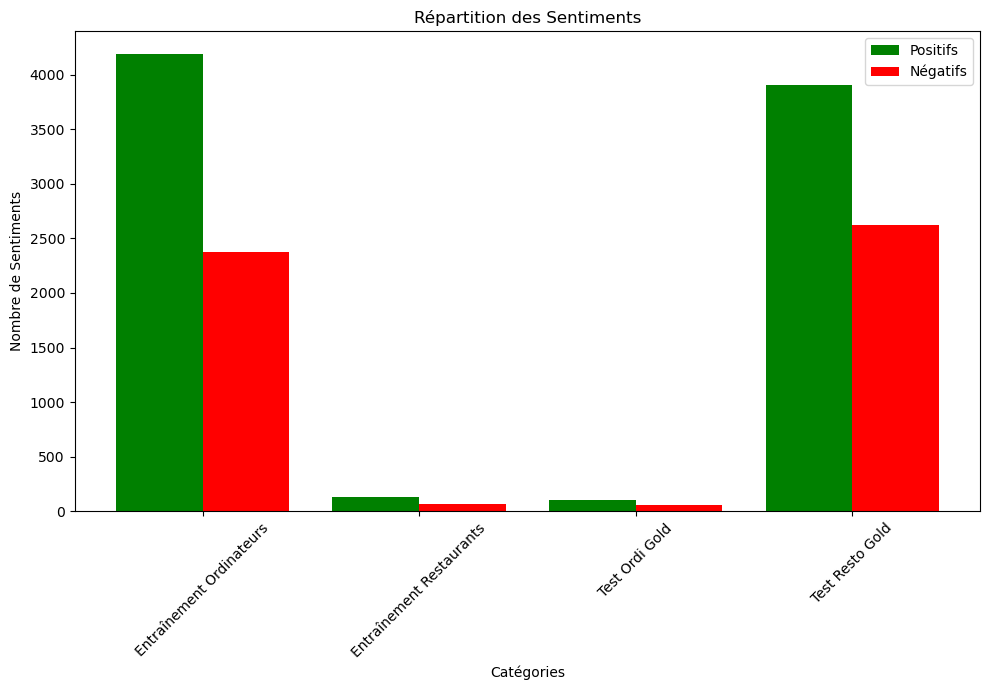

In [28]:
import matplotlib.pyplot as plt

def vis_dist_sent(chems):
    cp_pos, cp_neg = [], []

    for ch in chems:
        with open(ch, 'r', encoding='utf-8') as f:
            lignes = [eval(ligne) for ligne in f]  # Utilisation d'une liste pour stocker toutes les lignes
            pos, neg = sum(s_pos > 0 for _, _, s_pos, _ in lignes), sum(s_neg > 0 for _, _, _, s_neg in lignes)
        cp_pos.append(pos)
        cp_neg.append(neg)

    etqs = ['Entraînement Ordinateurs', 'Entraînement Restaurants', 'Test Ordi Gold', 'Test Resto Gold']
    poss = list(range(len(etqs)))

    # Ajustement pour séparer correctement les barres
    decalage = 0.4  # Décalage pour les barres pour éviter le chevauchement
    plt.figure(figsize=(10, 7))
    plt.bar([p - decalage / 2 for p in poss], cp_pos, width=decalage, label='Positifs', color='green', align='center')
    plt.bar([p + decalage / 2 for p in poss], cp_neg, width=decalage, label='Négatifs', color='red', align='center')
    
    plt.xlabel('Catégories')
    plt.ylabel('Nombre de Sentiments')
    plt.title('Répartition des Sentiments')
    plt.xticks(poss, etqs, rotation=45)  # Ajustement des étiquettes pour qu'elles soient centrées entre les barres
    plt.legend()
    plt.tight_layout()
    plt.show()

chems_fichs = [
    'C:/Users/ademb/Documents/TLN/output/Restaurants_Train_Sentiments.txt',
    'C:/Users/ademb/Documents/TLN/output/Restaurants_Test_Gold_Sentiments.txt',
    'C:/Users/ademb/Documents/TLN/output/Laptop_Test_Gold_Sentiments.txt',
    'C:/Users/ademb/Documents/TLN/output/Laptop_Train_Sentiments.txt',
]

vis_dist_sent(chems_fichs)


In [29]:
import xml.etree.ElementTree as ET
import nltk
from nltk.corpus import sentiwordnet as swn

# Téléchargement des ressources NLTK nécessaires
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')
nltk.download('punkt')

# Fonction pour lire et extraire les données depuis un fichier XML
def lire_et_extraire_xml(chemin_fichier):
    arbre = ET.parse(chemin_fichier)
    racine = arbre.getroot()
    donnees = []

    for phrase in racine.findall('.//sentence'):
        texte = phrase.find('text').text
        termes_aspect = phrase.find('aspectTerms')
        categories_aspect = phrase.find('aspectCategories')
        
        aspects = []
        if termes_aspect is not None:
            for terme in termes_aspect.findall('aspectTerm'):
                aspects.append({
                    'terme': terme.get('term'),
                    'polarite': terme.get('polarity'),
                    'de': int(terme.get('from')),
                    'a': int(terme.get('to'))
                })
        
        categories = []
        if categories_aspect is not None:
            for categorie in categories_aspect.findall('aspectCategory'):
                categories.append({
                    'categorie': categorie.get('category'),
                    'polarite': categorie.get('polarity')
                })
        
        donnees.append({'texte': texte, 'aspects': aspects, 'categories': categories})
    
    return donnees

# Calcul de la polarité basé sur les scores de SentiWordNet et ajusté par le POS tag
def calculer_polarite(termes, phrase, taille_fenetre=3):
    mots = nltk.word_tokenize(phrase)
    etiquettes_pos = nltk.pos_tag(mots)
    score_sentiment = 0

    for terme in termes:
        try:
            index_terme = mots.index(terme['terme'])  
        except ValueError:
            continue  # Le terme n'est pas trouvé dans les mots tokenisés

        debut_fenetre = max(0, index_terme - taille_fenetre)
        fin_fenetre = min(len(mots), index_terme + taille_fenetre + 1)
        
        for i in range(debut_fenetre, fin_fenetre):
            mot = mots[i].lower()
            pos_tag = etiquettes_pos[i][1]
            tag_swn = adapter_tag_pos(pos_tag)
            if not tag_swn:
                continue  # Saute les mots pour lesquels aucun tag compatible n'a été trouvé

            synsets = list(swn.senti_synsets(mot, tag_swn))
            for synset in synsets:
                score_base = synset.pos_score() - synset.neg_score()
                score_sentiment += score_base

    return 'positive' if score_sentiment > 0 else 'negative' if score_sentiment < 0 else 'neutral'


# Fonction principale pour traiter les fichiers et évaluer les sentiments
def traiter_et_evaluer_fichiers(fichiers_entrainement, fichiers_test_sans_etiquettes, fichiers_test_avec_etiquettes):
    predictions = {}

    for fichier in fichiers_test_sans_etiquettes:
        donnees = lire_et_extraire_xml(fichier)
        for donnee in donnees:
            for aspect in donnee['aspects']:
                polarite = calculer_polarite([aspect], donnee['texte'])
                predictions[(aspect['terme'], aspect['de'], aspect['a'])] = polarite

    
    print("Traitement terminé.")

# Exemple d'utilisation de la fonction
fichiers_entrainement = [
    "C:/Users/ademb/Documents/TLN/dataset/Restaurants_Train.xml",
    "C:/Users/ademb/Documents/TLN/dataset/Laptop_Train.xml"
]
fichiers_test_sans_etiquettes = [
    "C:/Users/ademb/Documents/TLN/dataset/Restaurants_Test_NoLabels.xml",
    "C:/Users/ademb/Documents/TLN/dataset/Laptop_Test_NoLabels.xml"
]
fichiers_test_avec_etiquettes = [
    "C:/Users/ademb/Documents/TLN/dataset/Restaurants_Test_Gold.xml",
    "C:/Users/ademb/Documents/TLN/dataset/Laptop_Test_Gold.xml"
]
traiter_et_evaluer_fichiers(fichiers_entrainement, fichiers_test_sans_etiquettes, fichiers_test_avec_etiquettes)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Traitement terminé.


In [32]:
import xml.etree.ElementTree as ET
import nltk
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from nltk.corpus import stopwords

# Téléchargements préalables des ressources NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# Fonction pour analyser les fichiers XML et créer un DataFrame
def extraire_donnees_de_xml(chemins):
    data_total = pd.DataFrame(columns=['Texte', 'TermeAspect', 'Polarite', 'Debut', 'Fin'])
    for chemin in chemins:
        arbre = ET.parse(chemin)
        racine = arbre.getroot()
        donnees = []
        for phrase in racine.findall('.//sentence'):
            texte = phrase.find('text').text
            termes_aspects = phrase.find('aspectTerms')
            if termes_aspects:
                for terme_aspect in termes_aspects.findall('aspectTerm'):
                    if terme_aspect.get('polarity') != 'conflict':
                        donnees.append({
                            'Texte': texte,
                            'TermeAspect': terme_aspect.get('term'),
                            'Polarite': terme_aspect.get('polarity'),
                            'Debut': terme_aspect.get('from'),
                            'Fin': terme_aspect.get('to')
                        })
        data_total = pd.concat([data_total, pd.DataFrame(donnees)], ignore_index=True)
    return data_total

# Configuration des chemins des fichiers d'entraînement
chemins_entree = [
    'C:/Users/ademb/Documents/TLN/dataset/Restaurants_Train.xml',
    'C:/Users/ademb/Documents/TLN/dataset/Laptop_Train.xml'
]

# Extraction des données
donnees = extraire_donnees_de_xml(chemins_entree)

# Prétraitement des textes
mots_vides = set(stopwords.words('english'))
vectoriseur = CountVectorizer(stop_words=list(mots_vides))  


# Préparation de la matrice de caractéristiques et des étiquettes
X = vectoriseur.fit_transform(donnees['Texte'])
y = donnees['Polarite'].apply(lambda x: 1 if x == 'positive' else -1 if x == 'negative' else 0)

# Séparation des données en ensemble d'entraînement et de test
X_entrainement, X_test, y_entrainement, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement du modèle
modele = RandomForestClassifier(random_state=42)
modele.fit(X_entrainement, y_entrainement)

# Prédiction et évaluation sur l'ensemble de test
predictions = modele.predict(X_test)
score = accuracy_score(y_test, predictions)
precision, rappel, f_score, _ = precision_recall_fscore_support(y_test, predictions, average='weighted')
print(f'Précision: {precision:.4f}, Rappel: {rappel:.4f}, F-Score: {f_score:.4f}, Score d\'exactitude: {score:.4f}')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ademb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Précision: 0.7107, Rappel: 0.7253, F-Score: 0.7141, Score d'exactitude: 0.7253
